# Lane Line Detection from Images

A pipeline that detects the lanes of a road and extracts information such as, radius of curvature and car offset.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from pprint import pprint
%matplotlib inline

In [2]:
# From https://github.com/naokishibuya/car-finding-lane-lines/blob/master/Finding%20Lane%20Lines%20on%20the%20Road.ipynb
def show_images(images, cols=2, cmap=None):
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10,11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        cmap = "gray" if len(image.shape) == 2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

In [3]:
def grayscale(img):
    """Returns a gray image from RGB"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

## Camera Calibration
Cameras often have some lens distortion which affects how an image looks. Objects in an image may look warped and do not represent the true size and shape of an object. In order to be able to extract data such as lane line curvature, images must first be undistorted.

To accomplish this, I used OpenCV's ability to detect a chessboard pattern and generated a matrix which undistorts all images from that particular camera. This works by creating a map of points of a distorted image, to points where it would be if the image was not distorted.

In [4]:
calibration_images = [plt.imread(name) for name in glob.glob("camera_cal/*.jpg")]

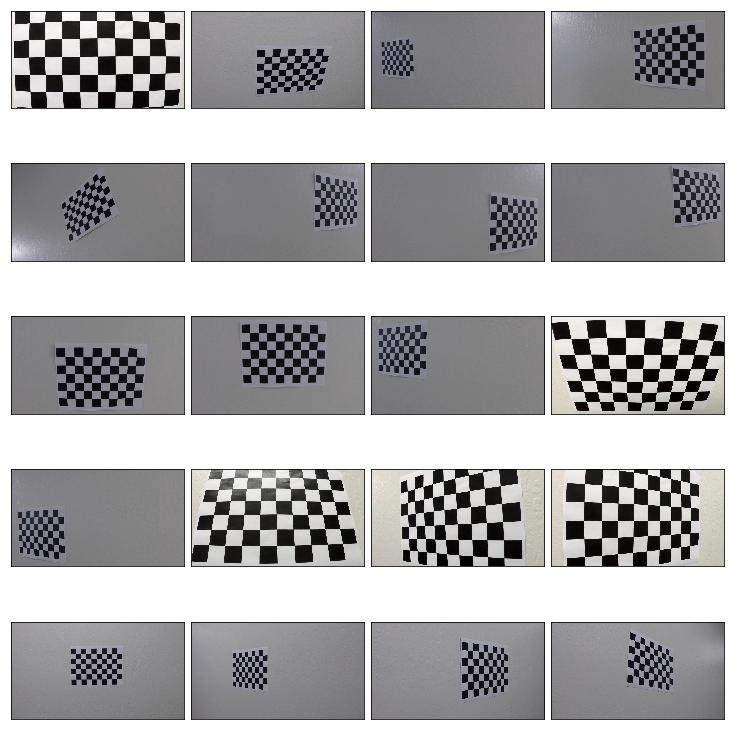

In [5]:
show_images(calibration_images, cols=4)

In [6]:
def draw_corners(img, nx, ny):
    """Draws corners of a chessboard"""
    img = np.copy(img)
    # Covnert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Identify corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        return img


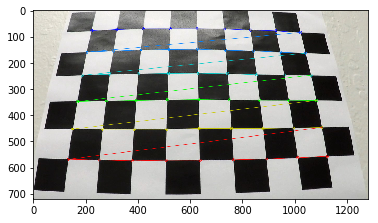

In [7]:
plt.imshow(draw_corners(calibration_images[13], 9, 6))

In [8]:
def calibrate_camera(images):
    """Returns camera calibration metrics
    Arguments:
    images: A set of images using checkerboard calibration
    """
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    # True location in grid
    objpoints = []
    # Location of corners in checkerboard
    imgpoints = []
    
    for image in images:
        gray = grayscale(image)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        # If checkboard is detected
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs
    
ret, mtx, dist, rvecs, tvecs = calibrate_camera(calibration_images)

Here we see some examples of images which are undistorted.

In [9]:
images = list(map(lambda image: cv2.undistort(image, mtx, dist, None, mtx), calibration_images))

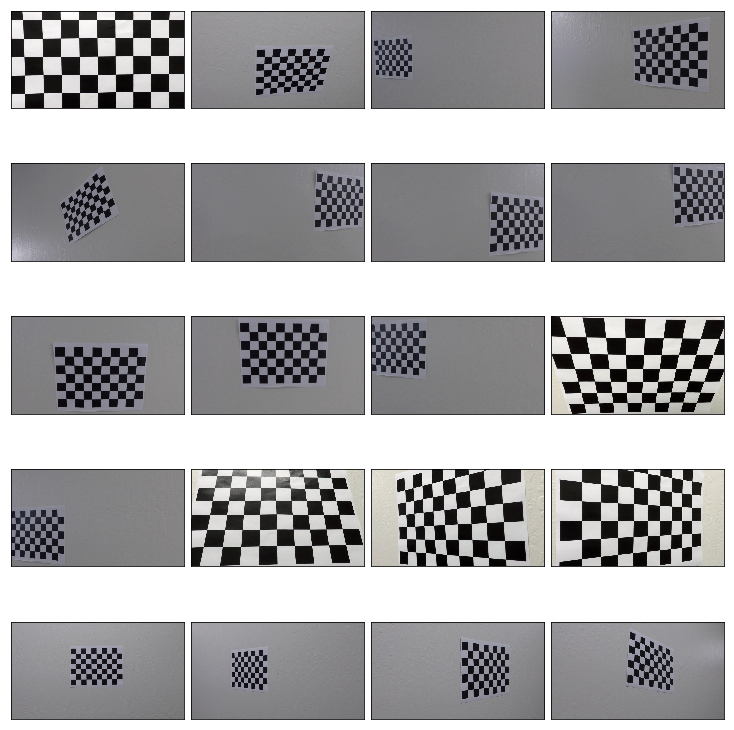

In [10]:
show_images(images, cols=4)

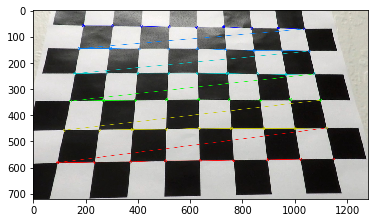

In [11]:
plt.imshow(draw_corners(images[13], 9, 6))

## Pipeline

- Undistort

In [12]:
# Load in test images
test_images = [plt.imread(name) for name in glob.glob("test_images/*.jpg")]

### Undistort

In [13]:
# Undistorts all test images
test_images = list(map(lambda image: cv2.undistort(image, mtx, dist, None, mtx), test_images))

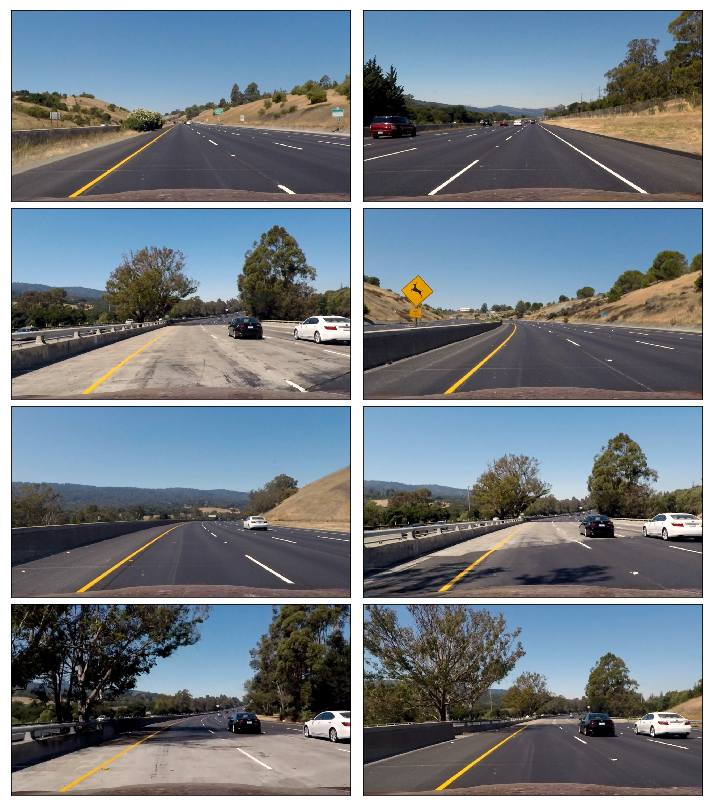

In [14]:
show_images(test_images) # Shows undistorted images

### Blurring
Blurring the image slightly will smoothen lines for better detections

In [15]:
blur = [cv2.GaussianBlur(img, (5, 5), 0) for img in test_images]

### Threshold Selection

In [16]:
from functools import reduce
def apply_masks_and(img, masks):
    # Returns all masks "and" together
    mask = reduce((lambda x, y: cv2.bitwise_and(x, y)), masks)
    return cv2.bitwise_and(img, img, mask=mask)

def apply_masks_or(img, masks):
     # Returns all masks "or" together
    mask = reduce((lambda x, y: cv2.bitwise_or(x, y)), masks)
    return cv2.bitwise_or(img, img, mask=mask)

In [17]:
def hls_select(img, h=(0,180), l=(0,255), s=(0,255)):
    """Selects parts of images within thresholds in HLS color space
    Arguments:
    img: An RGB image
    h: (int, int) in range 0-180
    l: (int, int) in range 0-255
    s: (int, int) in range 0-255
    Returns scaled mask multiplier
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    thresholds = np.array([h, l, s], dtype=np.uint8).T
    binary_output = cv2.inRange(hls, thresholds[0], thresholds[1])
    return binary_output

In [18]:
def color_select(img, r=(0,255), g=(0,255), b=(0,255)):
    """Selects parts of images with thresholds in RGB color space
    Arguments:
    img: An RGB image
    r, g, b: (int, int) in range 0-255
    Returns scaled mask multiplier
    """
    thresholds = np.array([r, g, b], dtype=np.uint8).T
    binary_output = cv2.inRange(img, thresholds[0], thresholds[1])
    return binary_output

In [19]:
def sobelx_select(img, sobel_kernel=3, thresh=(0, 255)):
    """Detects edges of an image using sobel horizontally
    Arguments:
    img: An RGB image
    sobel_kernel: Size of kernel (odd int >1)
    thresh: (int, int) in range 0-255
    Returns scaled mask multiplier
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take sobel with respect to x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    # Scale the sobel appropriately
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    binary_output = cv2.inRange(scaled_sobelx, thresh[0], thresh[1])
    return binary_output

In [20]:
def sobeldir_select(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """Detects edges of an image using sobel directionally
    Arguments:
    img: An RGB image
    sobel_kernel: Size of kernel (odd int >1)
    thresh: (double, double) in range 0-2*pi
    Returns scaled mask multiplier
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take separate gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take absolute value of gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Arctan2 gives direction of gradient
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # Create binary mask
    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir>thresh[0]) & (grad_dir<thresh[1])] = 1
    
    return binary_output.astype(np.uint8)

Here we used a combination of gradients and color thresholds to create a gray image. We extract parts of the image where vertical edges are detected within a certain threshold. Also, in HLS color space, we extract high saturated colors such as yellow. Combining these masks we generate a gray image that highlights what we detected.

In [21]:
hls_selection = [hls_select(img, (0,50),(100,255),(100,255)) for img in blur]

In [22]:
color_selection = [color_select(img, (180,255),(180,255),(180,255)) for img in blur]

In [23]:
sobelx_selection = [sobelx_select(img, thresh=(20, 100)) for img in blur]

In [24]:
# Apply masks to images
threshold = [apply_masks_or(img, [mask1, mask2]) for img, mask1, mask2 in zip(blur, color_selection, hls_selection)]
threshold = [apply_masks_and(img, [mask1]) for img, mask1 in zip(blur, sobelx_selection)]
# Convert to grayscale
threshold = [grayscale(img) for img in threshold]

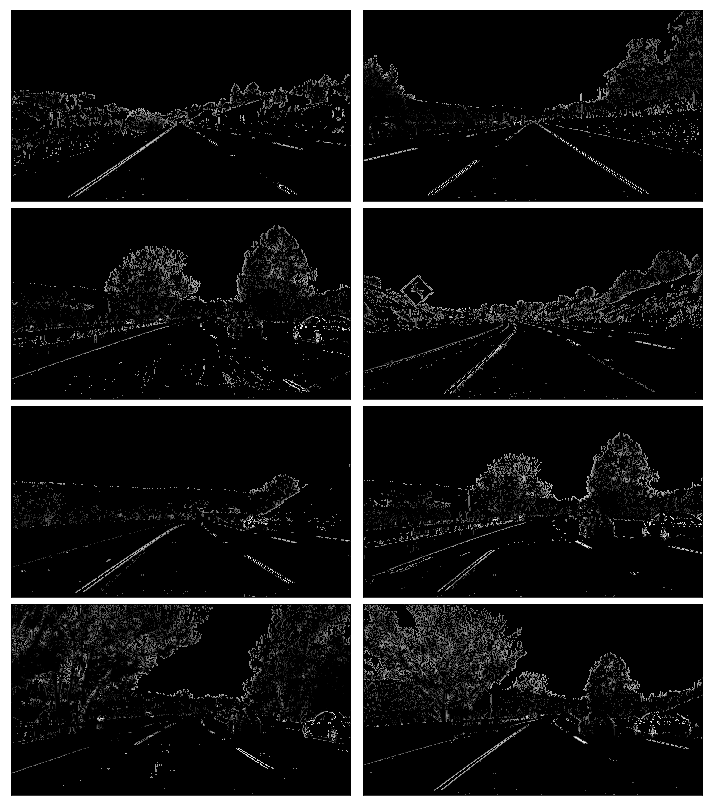

In [25]:
show_images(threshold, cmap="gray")

### Perspective Transform

In order to better detect the lane lines. We transfrom the image into a bird's eye veiew. We pick points on the original image and apply a perspective transform to where we want the points to show up. 

In [26]:
def get_perspective_matrices():
    """Generates persepctive matrix for bird's eye view
    Assumes constants for transform
    """
    img_size = (1280, 720)
    # Offset of left/right sides
    offset = 300
    # Pixels of the image assumed to represent a straight line
    # Top-Left, Top-Right, Bottom-Left, Bottom-Right
    src = np.float32([[572,469],[713,469],[278,677],[1031,677]])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset],
                                    [offset, img_size[1]],
                                     [img_size[0]-offset, img_size[1]]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

def birds_eye_view(img, M):
    "Returns a bird's eye perspective of the image"
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [27]:
M, Minv = get_perspective_matrices()

In [28]:
warped = [birds_eye_view(img, M) for img in threshold]

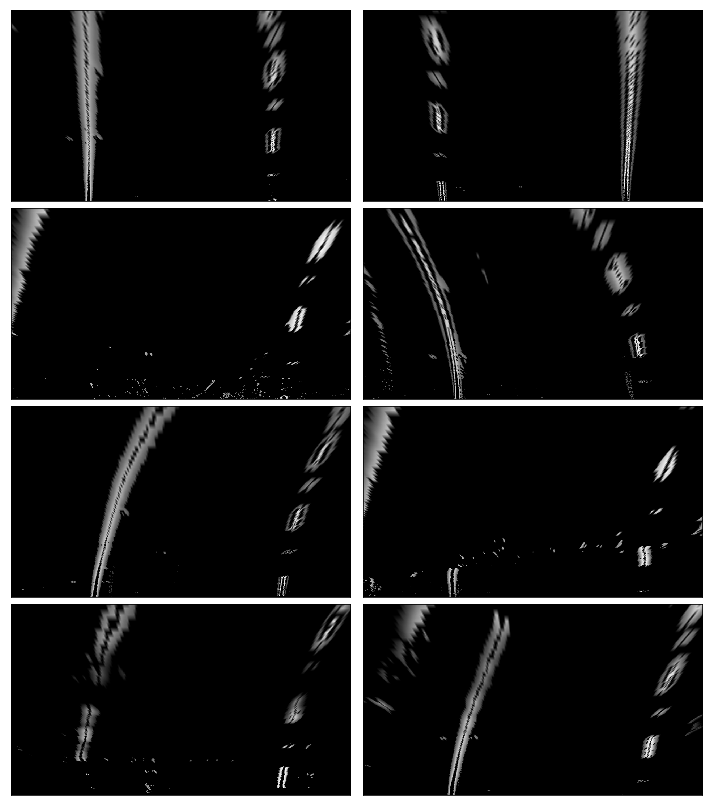

In [29]:
show_images(warped)

### Extract Line Information

Here we extract lane pixels that follow the pattern of a lane line.

In [30]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create a image to visualize results
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw windows for visualization
        cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                     (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low),
                     (win_xright_high, win_y_high), (0, 255, 0), 2)
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

    return leftx, lefty, rightx, righty, ploty, out_img

In [31]:
def fit_polynomial(binary_warped):
    """Returns polynomials of lane lines detected in image"""
    # Find lane pixels
    leftx, lefty, rightx, righty, ploty, out_img = find_lane_pixels(binary_warped)
    
    # Find a second order line
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #Only works for single images
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return left_fit, right_fit, ploty, out_img

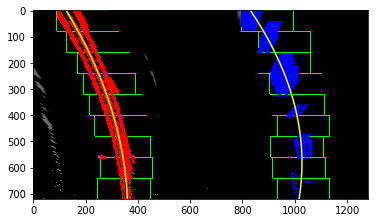

In [32]:
result = []
for img in warped[3:4]:
    left_fit, right_fit, ploty, out_img = fit_polynomial(img)
    result.append(out_img)
plt.imshow(result[0])
# show_images(result)

In [33]:
def draw_lane(warped, left_fit, right_fit, ploty):
    """Returns image annotated with lines drawn"""
    # Calculate lane points
    left_fitx = np.poly1d(left_fit)(ploty)
    right_fitx = np.poly1d(right_fit)(ploty)
    
    # Creates a blank image for lines to be drawn
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Converts points to cv2 format
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    
    return color_warp

In [34]:
def unwarp(img, Minv):
    """Returns unwapred image from bird's eye view"""
    img_size = (img.shape[1], img.shape[0])
    unwarp_img = cv2.warpPerspective(img, Minv, img_size)
    
    return unwarp_img

The graph with random yellow lines is caused by fit_polynomial's support for only one image

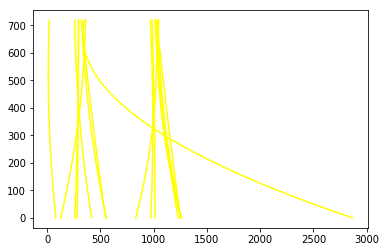

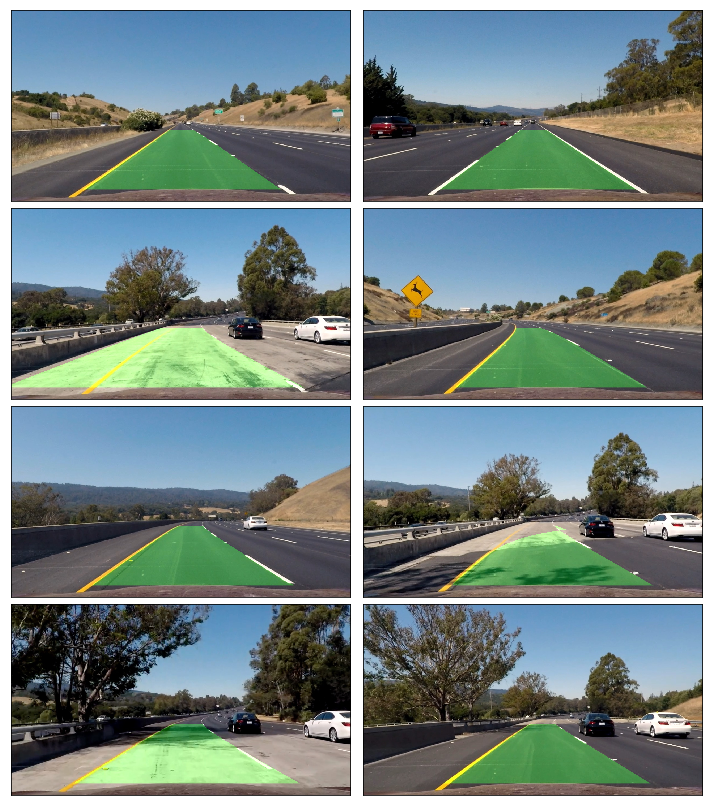

In [35]:
result = []
for undistort, image in zip(test_images, warped):
    left_fit, right_fit, ploty, out_img = fit_polynomial(image)
    lane = draw_lane(image, left_fit, right_fit, ploty)
    lane = unwarp(lane, Minv)
    result.append(cv2.addWeighted(undistort, 1, lane, 0.3, 0))
show_images(result)

In [36]:
def fit_polynomial_real(binary_warped, xm_per_pix=3.7/700, ym_per_pix=30/720):
    # Find lane pixels
    leftx, lefty, rightx, righty, ploty, out_img = find_lane_pixels(binary_warped)
    
    # Find a second order line
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return left_fit, right_fit, ploty

In [37]:
def measure_curvature_real(binary_warped, xm_per_pix=3.7/700, ym_per_pix=30/720):
    # Get real polynomial of the lane line
    left_fit, right_fit, ploty = fit_polynomial_real(binary_warped, xm_per_pix, ym_per_pix)
    
    # Find bottommost y-value
    y_eval = np.max(ploty)
    
    # Evaluate curvature based off lowest y input
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

In [38]:
curvature = [measure_curvature_real(img) for img in warped]

In [39]:
pprint(curvature)

[(8373.5489337786621, 1020.8529267747469),
 (2382.8999400205189, 2541.4752661088255),
 (641.60424371678062, 285.29543277579165),
 (419.86340929280107, 282.76746584929896),
 (558.10006502757415, 587.80617650397198),
 (29.020301959785233, 617.92847967630576),
 (622.29553748204762, 340.82366971838616),
 (2168.9505529198568, 2707.2950416194112)]


### Video Pipeline

In [40]:
from collections import deque

class Line:
    """Abstraction of a lane line find the best line based off of previous results
    """
    def __init__(self):
        self.allx = None
        self.ally = None
        self.mx = 3.7/700
        self.my = 30/720
        self.fits = deque(maxlen=15)
     
    def update(self, x, y, ploty):
        """Updates internal variables"""
        threshold = 50
        self.allx = x
        self.ally = y
        self.ploty = ploty
        # If the lane has too few points it is not detected
        if len(self.allx) > threshold:
            self.fits.append(np.polyfit(self.ally, self.allx, 2))
    
    @property
    def best_fit(self):
        """Averages previous lines"""
        return np.mean(self.fits, axis=0)
    
    @property
    def radius_of_curvature(self):
        """Returns radius of curvature in meters"""
        A, B, C = self.best_fit
        A *= self.mx/(self.my**2)
        B *= self.mx/self.my
        y_eval = np.max(self.ploty) * self.my
        radius = ((1 + (2*A*y_eval + B)**2)**1.5) / np.absolute(2*A)
        return radius
    
    def reset(self):
        self.fits.clear()
    


In [41]:
class LaneLineDetector:
    """A pipeline that takes images and annotates them with information"""
    def __init__(self, calibration_images):
        self.calibrate(calibration_images)
        self.left = Line()
        self.right = Line()
        self.M, self.Minv = get_perspective_matrices()
    
    def process(self, img):
        """Takes an image and returns an image annotated with
        The lane in green
        Curvatures of the lane lines
        Car offset"""
        img = np.copy(img)
        
        # Gaussian kernel
        kernel_size = 3
        sobelx_thresholds = (5, 255)
        hls_thresholds = ((0,50),(100,255),(100,255))
        color_thresholds = ((180,255),(180,255),(180,255))
        
        # Undistort image
        undistorted = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        # Blur image
        blur = cv2.GaussianBlur(undistorted, (kernel_size, kernel_size), 0)
        
        # Various masks
        sobelx_mask = sobelx_select(blur, thresh=sobelx_thresholds)
        hls_mask = hls_select(blur, h=hls_thresholds[0], l=hls_thresholds[1], s=hls_thresholds[2])
        color_mask = color_select(blur, r=color_thresholds[0], g=color_thresholds[1], b=color_thresholds[2])
        
        # Apply various masks
        threshold = apply_masks_or(blur, [hls_mask, color_mask])
        threshold = apply_masks_and(threshold, [sobelx_mask])
        gray_threshold = grayscale(threshold)
        
        # Changes the image to bird's eye view
        warped_binary = birds_eye_view(gray_threshold, M)
        
        # Detects lane lines from bird's eye view image 
        leftx, lefty, rightx, righty, ploty, out_img = find_lane_pixels(warped_binary)
        # Update each Line object
        self.left.update(leftx, lefty, ploty)
        self.right.update(rightx, righty, ploty)
        # Get best estimated lane lines
        left_fit = self.left.best_fit
        right_fit = self.right.best_fit
        
        # Draw lane on a blank canvas
        lane_warped = draw_lane(warped_binary, left_fit, right_fit, ploty)
        # Unwarp the lane image overlay
        lane_overlay = unwarp(lane_warped, Minv)
        
        # Format and annotate lane curvature
        unwarped_annotated = cv2.addWeighted(undistorted, 1, lane_overlay, 0.3, 0)
        curvature_text = "Left Rad: {:.2f}m Right Rad: {:.2f}".format(self.left.radius_of_curvature, self.right.radius_of_curvature)
        cv2.putText(unwarped_annotated, curvature_text,
                    (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
        
        # Format and annotate car offset
        center_text = "Car is {:.2f}cm right".format(self.distance_from_center(ploty)*100)
        cv2.putText(unwarped_annotated, center_text,
                    (100,200), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
        
        return unwarped_annotated
    
    def calibrate(self, images):
        """Calibrate the image inputs based off calibration images"""
        self.xsize = images[0].shape[1]
        self.ysize = images[1].shape[0]
        self.mx = 3.7/700
        self.my = 30/720
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = calibrate_camera(images)
        
    def distance_from_center(self, ploty):
        """Returns the car's lane offset in meters"""
        left_dist = np.poly1d(self.left.best_fit)(np.max(ploty))
        right_dist = np.poly1d(self.right.best_fit)(np.max(ploty))
        lane_center = (left_dist + right_dist) / 2
        # Center is assumed to be middle of the image
        center = self.xsize/2
        
        return (center-lane_center)*self.mx
        
    def reset(self):
        self.left.reset()
        self.right.reset()
        
calibration_images = [plt.imread(name) for name in glob.glob("camera_cal/*.jpg")]
detector = LaneLineDetector(calibration_images)

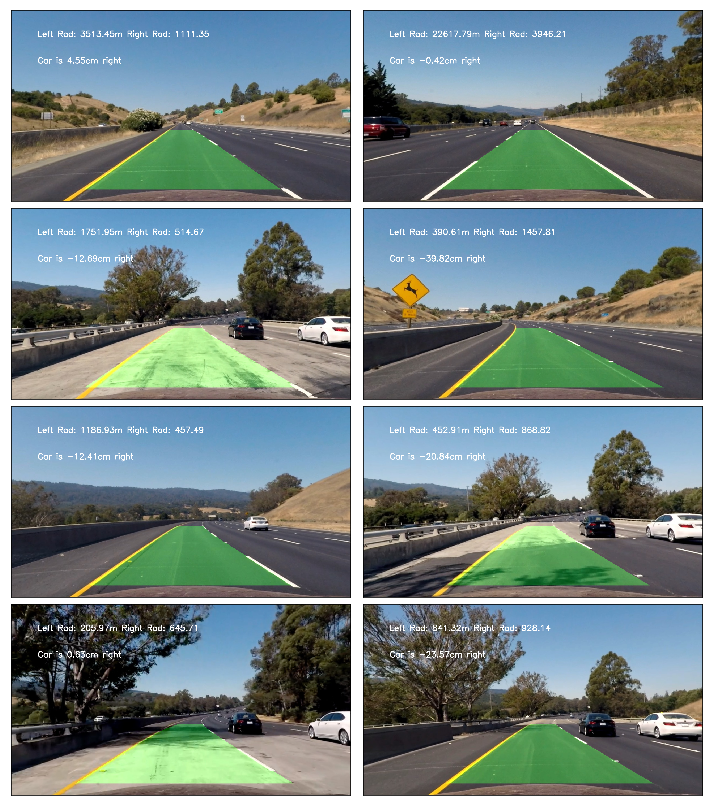

In [42]:
result = []
for img in test_images:
    detector.reset()
    result.append(detector.process(img))
show_images(result)

## Video Processing

In [43]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [44]:
detector.reset()
output = 'output_images/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(detector.process)
%time project_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:57<00:00, 10.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

Wall time: 1min 57s


In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Challenge Video
Changing light conditions still prove to be challenging for the pipeline. This can be alleviated by abstraction based on previous lines. Also, extrapolation of the right lane to check the left lane will suppress interferance from the road conditions

In [46]:
detector.reset()
challenge_output = 'output_images/challenge_video.mp4'
clip2 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip2.fl_image(detector.process)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video output_images/challenge_video.mp4
[MoviePy] Writing video output_images/challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:43<00:00, 11.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_video.mp4 

Wall time: 44.4 s


In [47]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

### Harder Challenge Video

In [48]:
detector.reset()
hard_challenge_output = 'output_images/harder_challenge_video.mp4'
clip3 = VideoFileClip("harder_challenge_video.mp4")
hard_challenge_clip = clip3.fl_image(detector.process)
%time hard_challenge_clip.write_videofile(hard_challenge_output, audio=False)

[MoviePy] >>>> Building video output_images/harder_challenge_video.mp4
[MoviePy] Writing video output_images/harder_challenge_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [02:02<00:00,  9.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/harder_challenge_video.mp4 

Wall time: 2min 3s


In [49]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(hard_challenge_output))